In [10]:
!pip install pydub

import mp3_utils
import matplotlib.pyplot as plt
import numpy as np

You are using pip version 18.0, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
def get_nonzero_blocks(arr):
    zero_entries = (arr == 0)
    consecutive_zero_blocks = np.copy(zero_entries).astype(np.int)
    for i in range(consecutive_zero_blocks.shape[0]):
        if (i > 0) and (consecutive_zero_blocks[i-1] > 0) and (consecutive_zero_blocks[i] > 0):
            consecutive_zero_blocks[i] = consecutive_zero_blocks[i-1] + 1
    return consecutive_zero_blocks

def get_nonzero_block_bounds(arr, len_cutoff):
    nonzero_blocks = get_nonzero_blocks(arr)
    above_cutoff_locs = np.where(nonzero_blocks >= len_cutoff)[0]
    true_locations_followed_by_false = []
    for i, loc in enumerate(above_cutoff_locs):
        if (i + 1) == above_cutoff_locs.shape[0]:
            true_locations_followed_by_false.append((loc, nonzero_blocks[loc]))
        else:
            if above_cutoff_locs[i+1] != (loc + 1):
                true_locations_followed_by_false.append((loc, nonzero_blocks[loc]))
    return true_locations_followed_by_false


def partition_nonzero_blocks(arr, len_cutoff=1):
    true_locations_followed_by_false = get_nonzero_block_bounds(arr, len_cutoff)
    partition_inds = []
    for loc, run_len in true_locations_followed_by_false:
        start, end = loc - run_len + 1, loc
        partition_inds.append(start)
        partition_inds.append(end)
    all_runs = []

    if arr[0] != 0: # need to add the first block
        run_start = 0
        run_end = arr.shape[0] if len(partition_inds) == 0 else partition_inds[0]
        run = (run_start, run_end), arr[run_start:run_end]
        all_runs.append(run)

    for start_ind in range(1, len(partition_inds), 2):  # start at end of first zero block
        if len(partition_inds) <= (start_ind + 1):  # don't go out of bounds
            continue
        run_inds = (partition_inds[start_ind] + 1, partition_inds[start_ind + 1])
        run = run_inds, arr[run_inds[0]:run_inds[1]]
        all_runs.append(run)
    
    if arr[-1] != 0 and len(partition_inds) > 0:  # need to add the last block
        run_inds = (partition_inds[-1] + 1, arr.shape[0])
        run = run_inds, arr[run_inds[0]:run_inds[1]]
        all_runs.append(run)

    return all_runs

def index_into_arr(all_runs, arr):
    other_runs = []
    for run_tup, _ in all_runs:
        run_start, run_end = run_tup
        other_runs.append((run_tup, arr[run_start:run_end]))
    return other_runs

# shitty test infra ayy
def test_fn(name, fn, inp):
    print(name)
    print(inp)
    print(fn(inp))

test_fn("normal", partition_nonzero_blocks, np.array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]))

test_fn("doesn't start with 0", partition_nonzero_blocks, np.array([1, 1, 1, 0, 0, 0, 1, 0]))

test_fn("doesn't end with zero", partition_nonzero_blocks, np.array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1]))

test_fn("short gaps", partition_nonzero_blocks, np.array([0, 1, 0, 1, 0, 1, 0]))

test_fn("all zeros", partition_nonzero_blocks, np.array([0, 0, 0, 0, 0, 0]))

test_fn("no zeros", partition_nonzero_blocks, np.array([1, 1, 1, 1, 1, 1]))

print("test indexing")
tst_arr = np.array([0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0])
print(index_into_arr(partition_nonzero_blocks(tst_arr), tst_arr))

normal
[0 0 0 1 1 1 0 0 0 1 0]
[((3, 6), array([1, 1, 1])), ((9, 10), array([1]))]
doesn't start with 0
[1 1 1 0 0 0 1 0]
[((0, 3), array([1, 1, 1])), ((6, 7), array([1]))]
doesn't end with zero
[0 0 0 1 1 1 0 0 0 1]
[((3, 6), array([1, 1, 1])), ((9, 10), array([1]))]
short gaps
[0 1 0 1 0 1 0]
[((1, 2), array([1])), ((3, 4), array([1])), ((5, 6), array([1]))]
all zeros
[0 0 0 0 0 0]
[]
no zeros
[1 1 1 1 1 1]
[((0, 6), array([1, 1, 1, 1, 1, 1]))]
test indexing
[((3, 6), array([2, 2, 2])), ((9, 10), array([2]))]


In [12]:
frame_rate, mp3_arr = mp3_utils.read(mp3_utils.FILE)
mp3_arr.shape

(4982784, 2)

In [13]:
magnitude_cutoff = 200
squish_below_cutoff = lambda arr: np.maximum(0, np.abs(arr) - magnitude_cutoff)

all_mp3_partitions = partition_nonzero_blocks(squish_below_cutoff(mp3_arr[:, 0]), len_cutoff=45)
orig_mp3_partitions = index_into_arr(all_mp3_partitions, mp3_arr[:, 0])

61
(354125, 404960)
[    0     1     2 ..., 50832 50833 50834]


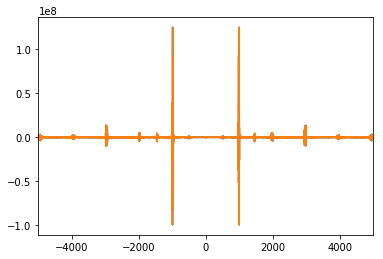

[  973.34907052   975.95160814   976.81912068   977.68663323   978.55414577
   980.28917085   981.15668339   982.89170847   984.62673355   985.49424609
   987.22927117   988.09678371   988.96429625   989.83180879   990.69932133
   991.56683387   992.43434641   993.30185896   994.1693715    995.03688404
   995.90439658   996.77190912   997.63942166   998.5069342   1001.10947182
  1002.8444969   1000.24195928   999.37444674   998.5069342    997.63942166
   996.77190912   995.90439658   995.03688404   994.1693715    993.30185896
   992.43434641   991.56683387   990.69932133   989.83180879   988.96429625
   987.22927117   986.36175863   984.62673355   982.89170847   982.02419593
   980.28917085   979.42165831   978.55414577   977.68663323   975.95160814
   975.0840956 ]
3436469.5556
[    0     1     2 ..., 50832 50833 50834]


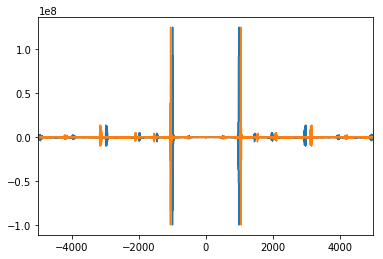

[ 1031.47241074  1034.07494836  1035.80997344  1036.67748598  1037.54499852
  1039.28002361  1040.14753615  1041.88256123  1043.61758631  1044.48509885
  1046.22012393  1047.08763647  1047.95514901  1048.82266155  1049.69017409
  1051.42519917  1052.29271171  1053.16022425  1054.0277368   1054.89524934
  1055.76276188  1056.63027442  1057.49778696  1058.3652995   1060.96783712
  1061.83534966  1059.23281204  1058.3652995   1057.49778696  1056.63027442
  1055.76276188  1054.89524934  1054.0277368   1053.16022425  1052.29271171
  1050.55768663  1049.69017409  1048.82266155  1047.95514901  1047.08763647
  1045.35261139  1044.48509885  1042.75007377  1041.01504869  1040.14753615
  1038.41251107  1037.54499852  1036.67748598  1034.9424609   1033.20743582
  1032.33992328]
3259089.00384
(0, 980.96809370469668, 1039.0039968883286, ('B', 5), ('C', 5))


In [49]:
def get_hz(partition, shift_key=0):
    partition_inds, partition_vals = partition
    ind_range = np.arange(partition_inds[0], partition_inds[1])
    
    spec = np.fft.fft(partition_vals)
    freq = np.fft.fftfreq(ind_range.shape[-1])
    
    sort_map = np.argsort(freq)
    rev_sort_map = np.argsort(sort_map)
    new_spec = np.zeros_like(spec, dtype=np.complex128)

    #print(sort_map[rev_sort_map])
    
    sorted_freq = freq[sort_map]
    
    shifted_freqs = freq * 2**(shift_key/12.)
    for i in range(shifted_freqs.shape[0]):
        freq_val = shifted_freqs[i]
        spec_val = spec[i]
        closest_ind = np.minimum(np.searchsorted(sorted_freq, freq_val), freq.shape[0]-1)
        #print(freq_val, spec_val, sorted_freq[closest_ind])
        new_spec[rev_sort_map[closest_ind]] += spec_val
    
    rev_partition = np.fft.ifft(new_spec)
    #spec = np.fft.fft(rev_partition)

    
    plt.plot(44100*freq, spec.real)
    plt.plot(44100*freq, new_spec.real)
    plt.xlim(-5000, 5000)
    #plt.plot(freq, spec.imag)
    plt.show()
    
    
    big_cutoff = np.percentile(np.abs(new_spec.real), 99.9)

    big_freqs = 44100*np.abs(freq[np.where(np.abs(new_spec.real) > big_cutoff)])
    #print(big_freqs)
    
    freqs_in_range = np.where(big_freqs < np.min(big_freqs) + 15)

    hz = np.mean(big_freqs[freqs_in_range])
    if shift_key == 0:
        return hz, rev_partition
    else:
        return hz, rev_partition

def hz_to_note(hz):
    # assumes A4 = 440 Hz
    all_note_names = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

    note_diff = int(round(12*np.log2(hz / 440)))
    
    octave = 4 + note_diff // 12
    note_ind = note_diff % 12
    note_name = all_note_names[note_ind]
    return note_name, octave

print(len(orig_mp3_partitions))
for i, partition in enumerate(orig_mp3_partitions):
    if i > 0:
        continue
    partition_inds, partition_vals = partition
    print(partition_inds)
    if partition_inds[1] - partition_inds[0] <= 150:  # arbitrary but fairly robust cutoff
        continue

    hz, vals = get_hz(partition, shift_key=0)
    print(np.linalg.norm(vals - partition_vals))
    new_hz, new_vals = get_hz(partition, shift_key=1)
    print(np.linalg.norm(new_vals - partition_vals))

    note, new_note = hz_to_note(hz), hz_to_note(new_hz)
    print(i, hz, new_hz, note, new_note)

In [9]:
trunc_mp3 = mp3_arr[:1300000]
mp3_utils.write("hotcrossbuns_abridged.mp3", frame_rate, trunc_mp3)

In [ ]:
fake_x = np.arange(1000)
fake_arr = np.sin(fake_x)
fake_spec = np.fft.fft(fake_arr)
fake_freq = np.fft.fftfreq(fake_x.shape[-1])

plt.plot(fake_freq, fake_spec.real, fake_freq, fake_spec.imag)
plt.show()

In [ ]:
# start, end =  354000, 405000
# start, end = 407000, 458000
# start, end = 459600, 511000
start, end = 404600, 407500
trunc_arr = mp3_arr[start:end, 0]
trunc_x = np.arange(start, end)
plt.plot(trunc_x, trunc_arr)
plt.show()

In [ ]:
trunc_spec = np.fft.fft(trunc_arr)
trunc_freq = np.fft.fftfreq(trunc_x.shape[-1])
plt.plot(trunc_freq, trunc_spec.real)
plt.plot(trunc_freq, trunc_spec.imag)
plt.show()

largest_freqs = np.argpartition(np.abs(trunc_spec.real), -20)[-20:]
for freq in largest_freqs:
    print(trunc_freq[freq]*44100, trunc_spec.real[freq], trunc_spec.imag[freq])

In [ ]:
for i, (partition_inds, partition_vals) in enumerate(orig_mp3_partitions):
    if partition_inds[1] - partition_inds[0] <= 150:  # arbitrary but fairly robust cutoff
        continue
    ind_range = np.arange(partition_inds[0], partition_inds[1])
    plt.plot(ind_range, partition_vals)
    plt.show()
    #fname = 'mp3_{}'.format(i)
    #get_note.write(fname, frame_rate, partition_vals)